# 将RGBA图片修改为RGB

In [33]:
import os
import cv2
'''png格式常常是32位的RGBA格式，A代表透明度，
   光是更改图片后缀，不能改变图片的位数，
   需要在openCV中进行色彩空间的转换，
   将png格式的32位RGBA转为jpg格式的24位RGB'''

def convert2jpg(filename):                                      # 将彩色图转灰度图的函数
    img = cv2.imread(file_path+'/'+filename, 1)                 # 1是以彩色图方式去读
    jpg_img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    cv2.imwrite(out_path + '/' + filename, jpg_img)             # 保存在新文件夹下，且图名中加GRAY

file_path = "./edit"                         # 输入文件夹
#os.mkdir("./edit")                           # 建立新的目录
out_path ="./attack"                           # 设置为新目录为输出文件夹

for filename in os.listdir(file_path):                          # 遍历输入路径，得到图片名
    print(filename)
    convert2jpg(filename)


test23.jpg
test24.jpg
test25.jpg
test26.jpg
test27.jpg
test29.jpg
test30.jpg
test31.jpg
test32.jpg
test33.jpg
test38.png
test39.png
test40.png
test41.png
test42.png


# 初始化数据集和网络

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
from skimage import io
import pandas as pd #用于更轻松的csv解析
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import cv2

print("ALIVE")

characters = ["marin", "miku", "kaguya"]

#数据集
class MyData(Dataset):
    def __init__(self, root_dir, csvfile, transform=transforms.ToTensor()):
        self.root_dir = root_dir#图像所在目录
        self.csv = pd.read_csv(csvfile)#标记所在目录
        print("DATA SET")
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
           
        #图片路径
        img_path = os.path.join(self.root_dir, self.csv.iloc[idx, 0])#单个图像路径    
        image_transform = transforms.Compose([
        # 将输入图片resize成统一尺寸
        transforms.Resize([128, 128]),
        # 将PIL Image或numpy.ndarray转换为tensor，并除255归一化到[0,1]之间
        transforms.ToTensor(),
        # 标准化处理-->转换为标准正太分布，使模型更容易收敛
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

        image = Image.open(img_path)#打开图像
        image = image_transform(image)
        label = self.csv.iloc[idx, 1]#打开图像对应标签
        label = np.array(label)#标签矩阵化
        return image, label, #返回图像和标签
    
    def __len__(self):
        return len(self.csv)#返回图片个数
    
#没有标准化处理的数据集，用作攻击
class MyData2(Dataset):
    def __init__(self, root_dir, csvfile, transform=transforms.ToTensor()):
        self.root_dir = root_dir#图像所在目录
        self.csv = pd.read_csv(csvfile)#标记所在目录
        print("DATA SET")
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
           
        #图片路径
        img_path = os.path.join(self.root_dir, self.csv.iloc[idx, 0])#单个图像路径
        
        image_transform = transforms.Compose([
        # 将输入图片resize成统一尺寸
        transforms.Resize([128, 128]),
        # 将PIL Image或numpy.ndarray转换为tensor，并除255归一化到[0,1]之间
        transforms.ToTensor(),
        # 标准化处理-->转换为标准正太分布，使模型更容易收敛
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])

        image = Image.open(img_path)#打开图像
        image = image_transform(image)
        label = self.csv.iloc[idx, 1]#打开图像对应标签
        label = np.array(label)#标签矩阵化
        return image, label, #返回图像和标签
    
    def __len__(self):
        return len(self.csv)#返回图片个数
    
    
#数据集对象实例化
mydata = MyData(root_dir = "./train", csvfile = "./train/train.csv")#训练数据
trainloader = torch.utils.data.DataLoader(mydata, batch_size = 10, shuffle = True)
testdata = MyData(root_dir = "./try", csvfile = "./try/try.csv")#测试数据
testloader = torch.utils.data.DataLoader(testdata, batch_size = 1, shuffle = True)
attackdata = MyData2(root_dir = "./attack", csvfile = "./attack/attack.csv")#攻击数据
attackloader = torch.utils.data.DataLoader(attackdata, shuffle = False)

#神经网络
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)#第一卷积层
        self.conv2 = nn.Conv2d(64, 1, 5)#第二卷积层
        self.fc1 = nn.Linear(1600, 3)#第一全连接层
        self.pool = nn.MaxPool2d(3, 3)#池化层
        
    def forward(self, x):
        x = F.relu(self.conv1(x))#第一层卷积后relu
        x = self.pool(F.relu(self.conv2(x)))#第二层卷积后relu且池化
        x = x.view(x.shape[0], -1)#将图片降维
        x = self.fc1(x)#带入第一全连接层
        return x
    
#神经网络对象实例化
print("MODEL SET")
net = MyNet()

#模型保存路径
PATH = ".\myModel.pth"


ALIVE
DATA SET
DATA SET
DATA SET
MODEL SET


# 训练神经网络

In [2]:
#定义损失和优化
MyLoss = nn.CrossEntropyLoss()#交叉熵
MyOptim = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)#更新权重使用SGD更新规则


print("Start training!!!")

for epoch in range(10):#训练十次防止过拟合
    runningLoss = 0
    print("\n-->EPOCH:", epoch)
    for i, data in enumerate(trainloader, 0):#遍历训练数据
        
        inputs, labels = data#带入训练数据
        
        MyOptim.zero_grad()#清零梯度
        
        #print(inputs.shape)
        outputs = net(inputs.to(torch.float32))#带入神经网络
        
        
        loss = MyLoss(outputs, labels)#计算损失
        
        
        loss.backward()#反向传播
        
       
        MyOptim.step()#更改权重
        
        runningLoss += loss.item()
        
    print("Loss", runningLoss)
    runningLoss = 0
        
  
print("\nProcess done...")


#保存神经网络模型

torch.save(net.state_dict(), PATH)
print("Successfully Saved...\n")

Start training!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

-->EPOCH: 0
Loss 77.36328850127757

-->EPOCH: 1
Loss 77.85505375638604

-->EPOCH: 2
Loss 34.306778864818625

-->EPOCH: 3
Loss 19.400922066008206

-->EPOCH: 4
Loss 24.181663360039238

-->EPOCH: 5
Loss 12.505109775094752

-->EPOCH: 6
Loss 10.561249633930856

-->EPOCH: 7
Loss 9.673353778627643

-->EPOCH: 8
Loss 7.666805502186662

-->EPOCH: 9
Loss 10.122568895174027

Process done...
Successfully Saved...



# 测试数据

In [31]:
net.load_state_dict(torch.load(PATH))

tc = [0,0,0]#统计各个人物出现的次数
c = [0,0,0]#统计各个人物识别正确的次数
#开始测试数据
total_correct = total = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images, labels = data
        #print(images.shape)
        outputs = net(images.to(torch.float32))
        name, predicts = torch.max(outputs.data, 1)
        if predicts == labels:
            total_correct += 1
            tc[labels] += 1
        total += 1
        c[labels] += 1
print("当前使用的是testloader数据集")
print("共计：", total, "正确：", total_correct,"准确率：", total_correct / total)
print("marin出现次数:", c[0], "正确：", tc[0],"准确率：", tc[0] / c[0])
print("miku出现次数：", c[1], "正确：", tc[1],"准确率：", tc[1] / c[1])
print("kaguya出现次数:", c[2], "正确：", tc[2],"准确率：", tc[2] / c[2])

当前使用的是testloader数据集
共计： 120 正确： 95 准确率： 0.7916666666666666
marin出现次数: 45 正确： 42 准确率： 0.9333333333333333
miku出现次数： 35 正确： 25 准确率： 0.7142857142857143
kaguya出现次数: 40 正确： 28 准确率： 0.7


# 攻击网络模型

C:\Users\jinle\AppData\Local\Temp\ipykernel_69028\2778709413.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ori = torch.tensor(ori)#转为tensor
C:\Users\jinle\AppData\Local\Temp\ipykernel_69028\2778709413.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


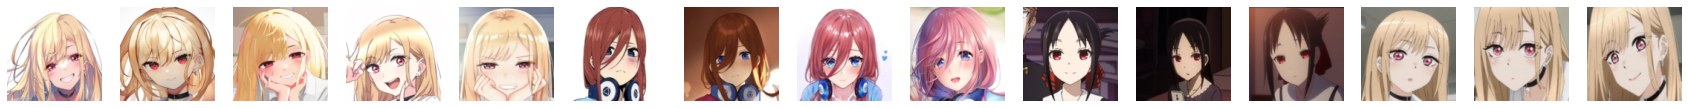

Epsilon: 0	Test Accuracy = 25 / 30 = 0.8333333333333334



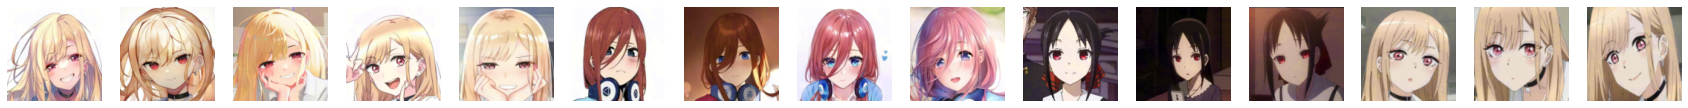

Epsilon: 0.01	Test Accuracy = 18 / 30 = 0.6



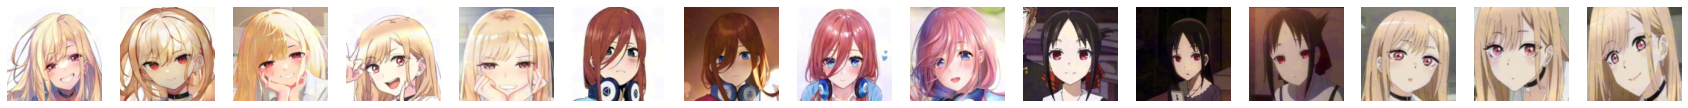

Epsilon: 0.015	Test Accuracy = 13 / 30 = 0.43333333333333335



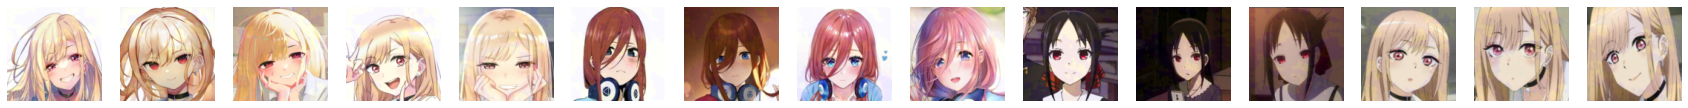

Epsilon: 0.02	Test Accuracy = 7 / 30 = 0.23333333333333334



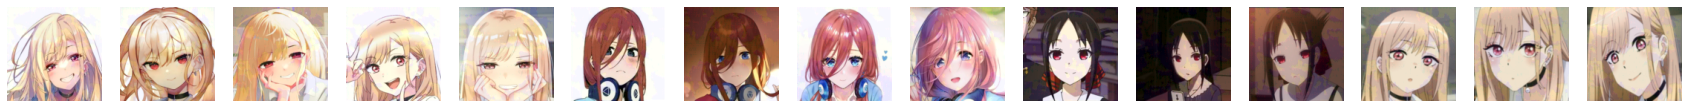

Epsilon: 0.025	Test Accuracy = 3 / 30 = 0.1



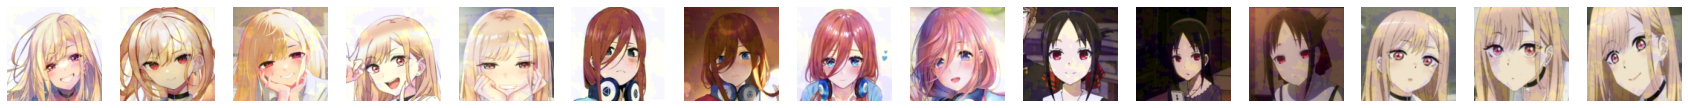

Epsilon: 0.03	Test Accuracy = 1 / 30 = 0.03333333333333333



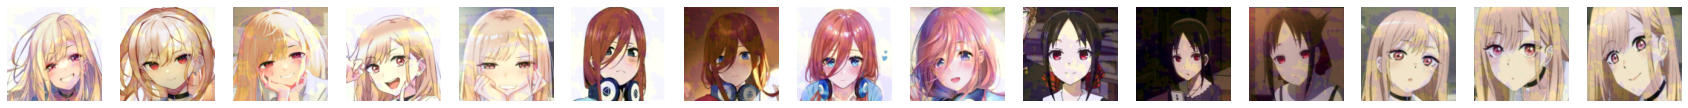

Epsilon: 0.035	Test Accuracy = 0 / 30 = 0.0



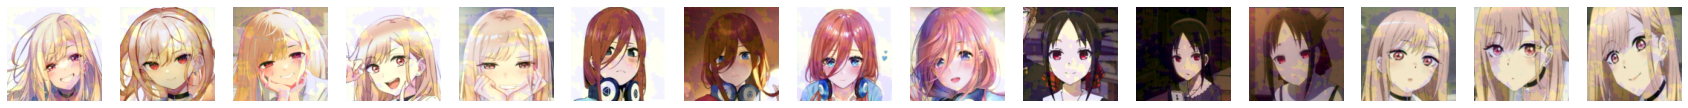

Epsilon: 0.04	Test Accuracy = 0 / 30 = 0.0



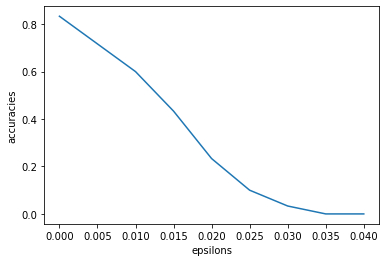

In [26]:
net.load_state_dict(torch.load(PATH))
net.eval()


#扰动
epsilons = [0, .01, .015, .02, .025, .03, .035, .04]
accuracies = []


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


def fgsm_attack(image, epsilon, data_grad):
    # 取图片张量每个元素的梯度
    sign_data_grad = data_grad.sign()
    # 在每个像素上添加扰动，幅度取决于epsilon
    perturbed_image = image + epsilon*sign_data_grad
    # 将图片张量的每个元素的取值控制在0和1之间
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回扰动图片
    return perturbed_image

#transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

def test( model, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    examples = []
    diffs = []
    
    #迭代梯度
    for data, labels in test_loader:   

        inputs, labels = data, labels
       
        inputs.requires_grad = True
        
        output=net(inputs)#带入图片

        init_pred = output.max(1, keepdim=True)[1] #开始预测

        if init_pred.item() != labels.item():#如果预测错误的话则是本来就分类错的样本
                continue#如果预测正确就是要进行扰动的样本

        loss = F.nll_loss(output,labels)#计算损失

        net.zero_grad()#清零模型梯度

        loss.backward()#反向传播

        data_grad = inputs.grad.data#获取反向传播的梯度

        perturbed_inputs = fgsm_attack(inputs, epsilon, data_grad)#制作扰动图像

        output = net(perturbed_inputs)#带入识别扰动图像

        final_pred = output.max(1, keepdim=True)[1]#看扰动后图像的标签
        
        if final_pred.item() == labels.item():#如果添加扰动后依然识别成功
            correct += 1
        
        #原本的图片
        ori = inputs[0]
        ori = torch.tensor(ori)#转为tensor
        ori = ori.detach().numpy()#去除梯度
        ori = np.transpose(ori, (1,2,0))#转置

        #加了扰动后的图片
        img = perturbed_inputs[0] # plt.imshow()只能接受3-d tensor，所以也要用image[0]消去batch那一维
        img = torch.tensor(img)
        img = img.detach().numpy() # floattensor转为ndarray
        img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后


        diff = 255*(ori-img)

        examples.append(img)
        diffs.append(diff)
        
    
    plt.figure(figsize=(30,30))
    
    for i in range(15):
        ax1 = plt.subplot(1, 15, i + 1) 
        ax1.axis("off")       
        ax1.imshow(examples[i])
    '''
    
    plt.imshow(diffs[10].astype(np.uint8))
    '''
    plt.show()
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, correct, len(test_loader), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc




# Run test for each epsilon
for eps in epsilons:
    acc= test(net, attackloader, eps)
    accuracies.append(acc)
    

plt.plot(epsilons, accuracies)
plt.xlabel("epsilons")
plt.ylabel("accuracies")
plt.show()